# Исследование оттока клиентов банка<a class="tocSkip">
<a id="start"></a>

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка</a></span><ul class="toc-item"><li><span><a href="#Численные-признаки" data-toc-modified-id="Численные-признаки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Численные признаки</a></span></li><li><span><a href="#Категориальные-признаки" data-toc-modified-id="Категориальные-признаки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Категориальные признаки</a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обработка пропусков</a></span></li><li><span><a href="#Обработка-аномалий" data-toc-modified-id="Обработка-аномалий-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обработка аномалий</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Построение-модели" data-toc-modified-id="Построение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Построение модели</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li></ul></li><li><span><a href="#Оценка-качества" data-toc-modified-id="Оценка-качества-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Оценка качества</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Описание проекта
### Записка к данным <a class="tocSkip">

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59.
___

Перед началом анализа импортируем необходимые библиотеки и создадим несколько функций для рисования графиков.  
Поскольку нам предстоит решать задачу классификации, создадим класс `GridSearch()` — аналог `GridSearchCV()` из `sklearn`, подбирающий помимо обычных гиперпараметров модели ещё и порог классификации, а также тип балансировки классов в обучающей выборке (*oversampling* / *undersampling* / без балансировки).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import notebook
from scipy import stats as st

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline

In [3]:
def plot_distribution(data_list, xlabels, title=None, kind='hist', bins=None, 
                      rotate_text=False, figsize=(15,6), fontsize=None):
    """ 
    Функция для отрисовки распределения значений признака.
    Для количественных признаков строит гистограмму + ящик с усами, для категориальных столбчатую диаграмму 
    """
    if kind == 'hist':
        fig, axes = plt.subplots(
            nrows=2, ncols=len(data_list), figsize=figsize, gridspec_kw={'height_ratios': [1, 4]}
        )
    else: fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)    
    plt.subplots_adjust(wspace=0.3, hspace=0)
    if title:
        plt.suptitle(title, fontsize=16)
    
    for i in range(len(data_list)):             
        if kind == 'hist':
            axes[0][i].set_facecolor('whitesmoke')
            axes[1][i].set_facecolor('whitesmoke')
               
            bottom_side = axes[0][i].spines['bottom']
            top_side = axes[1][i].spines['top']
            bottom_side.set_visible(False)
            top_side.set_visible(False)
            
            data_list[i].plot.hist(ax=axes[1][i], bins=bins[i], color='tomato', edgecolor='indianred', linewidth=2)
            axes[0][i].boxplot(
                data_list[i].dropna(), vert=False, patch_artist=True, notch=False, widths=0.3,
                boxprops=dict(facecolor='salmon', color='whitesmoke', lw=2),
                medianprops=dict(color='whitesmoke', lw=2),
                flierprops=dict(marker='o', markersize=10, markerfacecolor='whitesmoke', markeredgecolor='tomato'),
                whiskerprops=dict(color='salmon', lw=2),
                capprops=dict(lw=0)
            )
            axes[1][i].set_xlabel(xlabels[i], fontsize=14)
            axes[1][i].set_ylabel('Число объектов', fontsize=12)
            axes[0][i].set_xticks([])
            axes[0][i].set_yticks([])
            axes[1][i].grid(color='w', lw=1, axis='y')
            axes[1][i].set_axisbelow(True) 
            axes[1][i].yaxis.set_ticks_position('none') 
            
        elif kind == 'bar':
            axes[i].set_facecolor('whitesmoke')
            values = data_list[i].value_counts().sort_index()
            values.plot.bar(ax=axes[i], color='tomato', edgecolor='tomato', linewidth=2)
            k = 0
            if rotate_text:
                angle = 90
                axes[i].set_ylim(0, values.max() * 1.4)
                
            else:
                angle=0
                axes[i].set_ylim(0, values.max() * 1.2)
            for v in values:
                axes[i].text(k, v + 0.1 * values.max(), str(v), ha='center', 
                             fontsize=fontsize[i], color='dimgray', rotation=angle)
                k += 1
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
            
            axes[i].grid(color='w', lw=1, axis='y')
            axes[i].set_axisbelow(True)
            axes[i].xaxis.set_ticks_position('none')
            axes[i].yaxis.set_ticks_position('none')
            axes[i].set_xlabel(xlabels[i], fontsize=14)
            axes[i].set_ylabel('Число объектов', fontsize=12)
    plt.show()

In [4]:
def plot_box(data_list, labels, ticks, title=None, figsize=(15,6)):
    """ Функция для отрисовки ящика с усами """
    fig, axes = plt.subplots(figsize=figsize)    
    plt.subplots_adjust(wspace=0.3, top=0.8)
    if title:
        plt.suptitle(title, fontsize=16)
    axes.set_facecolor('whitesmoke')
    axes.boxplot(
        data_list, vert=False, patch_artist=True, notch=False, widths=0.4,
        boxprops=dict(facecolor='tomato', color='whitesmoke', lw=3),
        medianprops=dict(color='whitesmoke', lw=3),
        flierprops=dict(marker='o', markersize=15, markerfacecolor='whitesmoke', markeredgecolor='tomato'),
        whiskerprops=dict(color='orangered', lw=2),
        capprops=dict(lw=0)
    )        
    axes.set_xlabel(labels[0], fontsize=14)
    axes.set_ylabel(labels[1], fontsize=14)
    axes.grid(color='w', lw=1, axis='x')
    axes.set_yticklabels(ticks, fontsize=12)
    axes.xaxis.set_ticks_position('none')
    axes.yaxis.set_ticks_position('none')
    plt.show()
    return

In [5]:
def plot_scatter(data_list, xlabels, ylabels, title, alphas=[0.1,0.1,0.1], figsize=(15,6)):
    """ Функция для отрисовки диаграммы рассеяния """
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)    
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(title, fontsize=16)    
    for i in range(len(data_list)):             
        axes[i].set_facecolor('whitesmoke')
        
        x = np.array(data_list[i].dropna().iloc[:, 0])
        y = np.array(data_list[i].dropna().iloc[:, 1])
        right, left, top, bottom = max(x), min(x), max(y), min(y)
        axes[i].scatter(x, y, alpha=alphas[i], s=70, marker="X", facecolor='tomato', 
                        edgecolors='tomato')
        axes[i].set_xlabel(xlabels[i], fontsize=14)
        axes[i].set_ylabel(ylabels[i], fontsize=14)   
        axes[i].set_xlim(left - (right-left)/20, right + (right-left)/20)
        axes[i].set_ylim(bottom - (top-bottom)/20, top + (top-bottom)/20)
        
        axes[i].grid(color='w', lw=1, axis='both')
        axes[i].set_axisbelow(True)
        axes[i].xaxis.set_ticks_position('none')
        axes[i].yaxis.set_ticks_position('none')
    plt.show()

In [6]:
def plot_bar(data_list, xlabels, title=None, legend_titles=None, figsize=(15,5)):
    """ Функция для отрисовки столбчатой диаграммы """
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)    
    plt.subplots_adjust(wspace=0.3, hspace=0)
    if title:
        plt.suptitle(title, fontsize=16)
    color = ['lightsalmon', 'tomato', 'orangered', 'red']
    for i in range(len(data_list)):
        axes[i].set_facecolor('whitesmoke')
        data_list[i].plot(ax=axes[i], kind='bar', stacked=True, color=color)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
            
        axes[i].grid(color='w', lw=1, axis='y')
        axes[i].set_axisbelow(True)
        axes[i].xaxis.set_ticks_position('none')
        axes[i].yaxis.set_ticks_position('none')
        axes[i].set_xlabel(xlabels[i], fontsize=14)
        axes[i].set_ylabel('Доля объектов', fontsize=12)
        axes[i].legend(facecolor='ghostwhite', title=legend_titles[i], title_fontsize=12, 
                       ncol=2, shadow=True, fancybox=False, )
    plt.show()

In [7]:
def test_hypothesis(x, y=None, stat='ttest'):
    """ Функция для проверки гипотезы о совпадении функций распределения двух случайных величин """
    if stat == 'ttest':
        p = st.ttest_ind(x, y, equal_var=False).pvalue
    elif stat == 'mannwhitneyu':
        p = st.mannwhitneyu(x, y, alternative='two-sided').pvalue
    elif stat == 'chi2':
        _, p, _, _ = st.chi2_contingency(x)

    return p

In [8]:
def cv_score(x, y, estimator, thresholds, balance, cv):  
    """ 
    Вспомогательная функция класса GridSearch().
    Для каждого разбиения выборки на обучение и валидацию производит балансировку классов в обучающей выборке, 
    обучает модель, находит предсказания на валидацционной выборке и подбирает оптимальный порог классификации.
    Возвращает лучшую F1-меру и соответствующий порог
    """
    kf = StratifiedKFold(n_splits=cv, random_state=42)
    cv_scores = []
    cv_thresholds = []
    
    for train_index, valid_index in kf.split(x, y):
        x_train, y_train = balance_sample(x.iloc[train_index], y.iloc[train_index], how=balance)
        x_valid, y_valid = x.iloc[valid_index], y.iloc[valid_index]
        estimator.fit(x_train, y_train)
        probabilities = estimator.predict_proba(x_valid)[:, 1]

        best_score = 0
        best_threshold = 0
        for threshold in thresholds:
            y_pred = (probabilities > threshold) * 1
            score = f1_score(y_valid, y_pred)
            if score > best_score:
                best_score = score
                best_threshold = threshold
                
        cv_scores.append(best_score)
        cv_thresholds.append(best_threshold)
        
    return np.mean(cv_scores), np.mean(cv_thresholds)

In [9]:
def parameters_list(parameters_grid):
    """ 
    Вспомогательная функция класса GridSearch().
    Переводит словарь parameters_grid в список наборов гиперпараметров 
    """
    keys = list(parameters_grid.keys())
    params_product = list(product(*parameters_grid.values()))
    return [{keys[i]: params[i] for i in range(len(params))} for params in params_product]

In [10]:
def balance_sample(x, y, how):
    """ Функция производит балансировку классов """
    if how == None:
        return x, y
    negative_y = y[y == 0]
    positive_y = y[y == 1]
    
    if how == 'over':
        positive_y_new_samples = positive_y.sample(
            n=len(negative_y) - len(positive_y), replace=True, random_state=42
        )
        y_balanced = pd.concat([negative_y, positive_y, positive_y_new_samples])
        
    elif how == 'under':
        negative_y_downsampled = negative_y.sample(n=len(positive_y), replace=False, random_state=42)
        y_balanced = pd.concat([negative_y_downsampled, positive_y])
        
    x_balanced = x.loc[y_balanced.index]    
    x_balanced, y_balanced = shuffle(x_balanced, y_balanced, random_state=42)    
    return x_balanced, y_balanced

In [11]:
class GridSearch():
    """ Поиск оптимальных гиперпараметров """
    def __init__(self, estimator, parameters_grid, thresholds, cv=3, balance=None):
        """
        - estimator : estimator object
        - parameters_grid : dict
            Словарь вида {гиперпараметр: список_значений}
        - thresholds : list
            Список значений порога классификации
        - cv : int, default=3
            Число фолдов
        - balance : str, default=None
            Метод балансировки классов. Возможные значения:
            - None, без балансировки классов
            - 'over', случайный oversampling
            - 'under', случайный undersampling
        """
        self.estimator = estimator
        self.parameters = parameters_list(parameters_grid)
        self.thresholds = thresholds
        self.cv = cv
        self.balance = balance
    
    def fit(self, x_train, y_train):
        x = x_train.copy()        
        y = y_train.copy()
        scores = []
        thrs = []
        for params in notebook.tqdm(self.parameters):
            self.estimator.set_params(**params)
            score, thr = cv_score(x, y, self.estimator, self.thresholds, self.balance, self.cv)
            scores.append(score)
            thrs.append(thr)
            
        self.best_score = max(scores)
        self.best_params = self.parameters[scores.index(self.best_score)]
        self.best_thr = thrs[scores.index(self.best_score)]
        result = pd.DataFrame(self.parameters)
        result['threshold'] = thrs
        result['score'] = scores
        self.cv_results = result
        return self

In [12]:
def get_cv_scores(x, y, estimator, threshold, balance=None, cv=3, split_info=False, roc_plot=False, label=None):   
    """ 
    Функция для кросс-валидационной оценки качества модели. 
    Возвращает метрики качества F1, accuracy, precision и recall, а также время обучения/предсказания
    """
    kf = StratifiedKFold(n_splits=cv, random_state=42)
    cv_scores = pd.DataFrame(columns=['F1', 'accuracy', 'AUC-ROC', 'precision', 
                                      'recall', 'learning_time', 'prediction_time'], dtype=float)
    i = 0
    fprs, tprs = [], []
    for train_index, valid_index in kf.split(x, y):
        start_learn = time.time()
        x_train, y_train = balance_sample(x.iloc[train_index], y.iloc[train_index], how=balance)
        x_valid, y_valid = x.iloc[valid_index], y.iloc[valid_index]
        estimator.fit(x_train, y_train)
        end_learn = time.time()
        probas = estimator.predict_proba(x_valid)[:, 1]
        y_pred = (probas > threshold) * 1
        end_predict = time.time()
        cv_scores.loc['split ' + str(i)] = [
            f1_score(y_valid, y_pred),
            roc_auc_score(y_valid, probas),
            accuracy_score(y_valid, y_pred),
            precision_score(y_valid, y_pred),
            recall_score(y_valid, y_pred),
            end_learn - start_learn,
            end_predict - end_learn
        ]
        if roc_plot:
            fpr, tpr, _ = roc_curve(y_valid, probas, pos_label=1, drop_intermediate=False)
            fprs.append(fpr)
            tprs.append(tpr)
        i += 1
    if roc_plot:
        plot_roc(np.array(fprs), np.array(tprs), cv=cv, label=label)
    if split_info:
        return cv_scores
    return cv_scores.mean()

In [13]:
def reshape_fpr_tpr(x, y, step=0.01):
    """ 
    Вспомогательная функция для функции plot_roc(). 
    Из списков значений TPR и FPR для каждого разбиения на фолды создаёт два списка: 
    список значений FPR от 0 до 1 с заданным шагом и список соответствующих значений TPR 
    """
    x2 = np.arange(0, 1 + step/2, step)
    y2 = [
        [y[j][k] for j in range(3) for k in range(len(x[j])) if x[j][k] >= x2[i] and x[j][k] < x2[i+1]] 
        for i in range(len(x2) - 1)
    ]
    y2.append([y[j][k] for j in range(3) for k in range(len(x[j])) if x[j][k] == x2[-1]])
    return x2, y2

In [14]:
def plot_roc(fpr, tpr, cv=False, label='Модель'):
    """ Функция для отрисовки ROC-кривой """
    fig, axes = plt.subplots(figsize=(7,5))    
    axes.set_facecolor('whitesmoke')
    if cv:
        fpr, tpr = reshape_fpr_tpr(fpr, tpr, step=0.01)
        colors = ['lightsalmon', 'tomato', 'orangered']
        axes.fill_between(fpr, [min(s) for s in tpr], [max(s) for s in tpr],
                          color='tomato', label=label + ' (cv={})'.format(cv), lw=2)
    else:
        axes.plot(fpr, tpr, color='tomato', linewidth=4, label=label)
    axes.plot([0, 1], [0, 1], ':', linewidth=3, color='tomato', label='Константная модель')
    axes.legend(facecolor='ghostwhite', ncol=1, shadow=True, fancybox=False, loc='lower right')
    axes.set_title('ROC-кривая', fontsize=16, pad=20)
    axes.set_xlabel('FPR', fontsize=14)
    axes.set_ylabel('TPR', fontsize=14)
    axes.grid(color='w', lw=1, axis='both')
    axes.set_axisbelow(True)
    axes.xaxis.set_ticks_position('none')
    axes.yaxis.set_ticks_position('none')
    plt.show()

# Обзор данных 
[к оглавлению](#start)

Откроем файл и изучим общую информацию.

In [15]:
data = pd.read_csv('Churn.csv', index_col='RowNumber')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Преобразуем названия столбцов, чтобы с ними было проще работать.

In [16]:
data.columns = ['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure',
                'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']
data.index.names = [None]

Итак, в таблице 13 столбцов:

In [17]:
labels = {
    'customer_id': 'Идентификатор клиента', 
    'surname': 'Фамилия', 
    'credit_score': 'Кредитный рейтинг', 
    'geography': 'Страна проживания', 
    'gender': 'Пол', 
    'age': 'Возраст, годы', 
    'tenure': 'Количество недвижимости',
    'balance': 'Баланс на счёте', 
    'num_of_products': 'Количество продуктов банка',
    'has_cr_card': 'Наличие кредитной карты', 
    'is_active_member': 'Активность клиента', 
    'estimated_salary': 'Предполагаемая зарплата', 
    'exited': 'Факт ухода'
}

Пропуски отсутствуют во всех столбцах, кроме `tenure`. Типы данных правильные: категориальные переменные имеют тип `object`, численные — `int64` или `float64`. Имеет смысл привести значения в столбце `tenure` к целочисленному типу.

Индекс строк не несёт смысловой нагрузки. Строки в таблице, похоже, никак не упорядочены. 

In [18]:
data.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,101348.880,1
2,15647311,Hill,608,Spain,Female,41,1.000,83807.860,1,0,1,112542.580,0
3,15619304,Onio,502,France,Female,42,8.000,159660.800,3,1,0,113931.570,1
4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,93826.630,0
5,15737888,Mitchell,850,Spain,Female,43,2.000,125510.820,1,1,1,79084.100,0


### Вывод<a class="tocSkip">
Первичный анализ данных выявил следующие особенности.
* В столбце `tenure` имеются пропуски.
* Тип данных в столбце `tenure` необходимо изменить.
* В таблице присутствуют категориальные признаки.

Выполним предобработку.

# Предобработка
[к оглавлению](#start)

Проверим уникальные идентификаторы клиентов.

In [19]:
print('Число одинаковых id клиента:', (data['customer_id'].value_counts() > 1).sum())

Число одинаковых id клиента: 0


Всё верно: у каждого клиента свой уникальный идентификатор. Теперь можно удалить столбец `customer_id`, т.к. он не представляет интереса для исследования.

In [20]:
data = data.drop(columns=['customer_id'])

### Деление выборки на обучение и тест <a class="tocSkip">

Делим выборку в отношении 3:1. Далее в проекте качество модели будем оценивать на кросс-валидации, поэтому отдельную валидационную выборку создавать не будем.

In [21]:
data, test_data = train_test_split(data, test_size=0.25, random_state=42, shuffle=True, stratify=data['exited'])
print('{} объектов в обучении и {} в тесте'.format(len(data), len(test_data)))

7500 объектов в обучении и 2500 в тесте


Проверим, насколько тестовая выборка похожа на обучающую. Для этого добавим новый признак — индикатор принадлежности объекта к обучающей выборке и оценим на кросс-валидации качество классификатора, предсказывающего, принадлежит ли объект обучающей выборке [[1]](https://habr.com/ru/post/422185/).

Выберем метрику качества AUC ROC. В качестве классификатора будем использовать `CatBoostClassifier()`, т.к. он не требует предварительной обработки категориальных признаков.

In [22]:
def check_split(train_data, test_data, cat_features):
    train = train_data.copy()
    test = test_data.copy()
    train['is_train'] = 1
    test['is_train'] = 0
    data = pd.concat([train, test], axis=0, ignore_index=True)
    data = shuffle(data, random_state=42)
    clf = CatBoostClassifier(random_state=42, cat_features=cat_features, iterations=50, verbose=False)
    return cross_val_score(
           clf, X=data.drop(columns=['is_train']), y=data['is_train'], cv=3, scoring='roc_auc'
           ).mean()

In [23]:
print('AUC ROC = {:.3f}'.format(check_split(data, test_data, cat_features=['surname', 'geography', 'gender'])))

AUC ROC = 0.491


Качество как у случайного классификатора $\to$ разбиение на обучение и тест хорошее :)

## Численные признаки

Перейдём к предобработке численных признаков.

In [24]:
num_columns = ['credit_score', 'balance', 'estimated_salary', 'age', 'tenure', 'num_of_products']

In [25]:
data[num_columns].describe().loc[['min', '50%', 'mean', 'max']]

,credit_score,balance,estimated_salary,age,tenure,num_of_products
min,350.000,0.000,11.580,18.000,0.000,1.000
50%,652.000,96943.320,98940.675,37.000,5.000,1.000
mean,650.508,76328.197,99540.472,38.980,5.001,1.532
max,850.000,222267.630,199992.480,92.000,10.000,4.000


В данных отсутствуют артефаты (вроде отрицательных или слишком больших значений). У признаков `balance` и `num_of_products` среднее и медиана отличаются, что говорит о скошенности их распределений.  

Построим гистограммы.

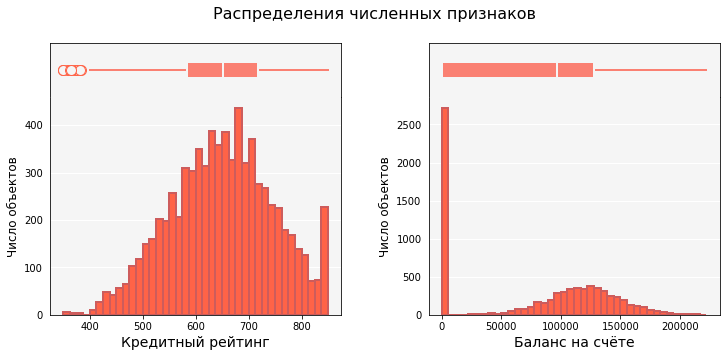

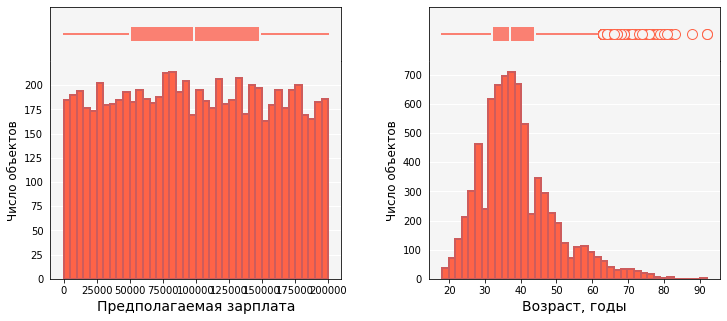

In [26]:
plot_distribution(
    [data[col] for col in num_columns[:2]], kind='hist', bins=[40] * 2, figsize=(12,5),
    xlabels=[labels[col] for col in num_columns[:2]], title='Распределения численных признаков'
)
plot_distribution(
    [data[col] for col in num_columns[2:4]], kind='hist', bins=[40] * 2, figsize=(12,5), 
    xlabels=[labels[col] for col in num_columns[2:4]]
)

* Кредитный рейтинг имеет распределение, близкое к нормальному. Но виден узкий пик в области максимального рейтинга 850.
* Распределение клиентов по балансу на счёте бимодально: присутствует высокий пик в нуле и более низкий и широкий пик в области ~1.2e5, форма которого близка к нормальной. Число клиентов с нулевым балансом довольно большое. 
* Предполагаемая зарплата клиентов распределена равномерно.
* Возраст имеет унимодальное распределение с тяжёлым правым хвостом. Средний возраст клиентов 38 лет. 

Изучим распределения оставшихся дискретных признаков.

In [27]:
data['tenure'] = data['tenure'].astype('Int64')
test_data['tenure'] = test_data['tenure'].astype('Int64')

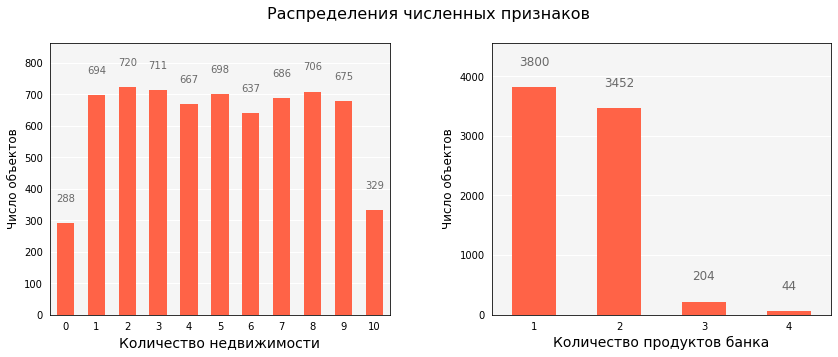

In [28]:
plot_distribution(
    [data[col] for col in num_columns[4:]], kind='bar', figsize=(14, 5),
    xlabels=[labels[col] for col in num_columns[4:]], title='Распределения численных признаков', fontsize=[10,12]
)

* Количество недвижимости, похоже, распределено равномерно. 
* Распределение `num_of_products` скошено влево — большинство клиентов пользуется одним-двумя продуктами банка.

Перейдём к бинарным признакам. Это пол клиента, активность, наличие кредитной карты, а также таргет — факт ухода клиента из банка.  
Для начала закодируем `gender`.

In [29]:
data['gender'].value_counts(normalize=True).to_frame()

,gender
Male,0.551
Female,0.449


In [30]:
encoder = OrdinalEncoder()
data['gender'] = encoder.fit_transform(data[['gender']])
test_data['gender'] = encoder.transform(test_data[['gender']])

Теперь посмотрим на распределения значений бинарных признаков.

In [31]:
bool_columns = ['has_cr_card', 'is_active_member', 'gender']
data[bool_columns + ['exited']].describe().loc[['min', 'mean', 'max']]

,has_cr_card,is_active_member,gender,exited
min,0.000,0.000,0.000,0.000
mean,0.707,0.517,0.551,0.204
max,1.000,1.000,1.000,1.000


Все признаки принимают только два значения: 0 и 1.  
У большинства клиентов есть кредитная карта, примерно половина клиентов активны, доля мужчин среди клиентов банка немного превышает долю женщин. Пятая часть клиентов ушла из банка $\to$ выборка несбалансированная. 

Итак, среди значений численных признаков нет артефактов и выбросов. Распределения выглядят правдоподобно.  
Масштабы значений численных признаков сильно отличаются, что может повлиять на качество, например, линейных моделей. Далее мы сравним качество моделей, обученных на не масштабированных, нормализованных и стандартизированных данных.

## Категориальные признаки
[к оглавлению](#start)

У нас осталось ещё 2 категориальных признака: фамилия клиента и страна проживания.

In [32]:
data['surname'].value_counts().to_frame().head(10)

,surname
Smith,25
Martin,25
Scott,22
Walker,21
Brown,20
Genovese,20
Shih,19
Yeh,19
Wang,19
T'ien,18


В выборке есть повторяющиеся фамилии клиентов. Поскольку все идентификаторы клиентов уникальны, можно считать, что это разные люди с одинаковыми фамилиями.  
Признак `surname` не может быть связан с таргетом, поэтому удалим его из таблицы.

In [33]:
data, test_data = data.drop(columns=['surname']), test_data.drop(columns=['surname'])

In [34]:
data['geography'].value_counts(normalize=True).to_frame()

,geography
France,0.499
Spain,0.252
Germany,0.249


Половина клиентов банка проживает во Франции, по четверти — в Германии и Испании.

Категориальный признак необходимо закодировать. Далее мы сравним техники кодирования *One-Hot Encoding* и *Ordinal Encoding* и выберем лучшую модель.

## Обработка пропусков

Обработаем пропуски в поле `tenure`. Посмотрим на информацию о клиентах с неизвестным числом недвижимости.

In [35]:
data[data['tenure'].isna()].head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
5867,735,France,0.000,53,NaN,123845.360,2,0,1,170454.930,1
6694,637,France,1.000,27,NaN,128940.240,1,1,0,46786.920,0
4919,717,France,0.000,36,NaN,99472.760,2,1,0,94274.720,1
342,659,France,1.000,31,NaN,118342.260,1,0,0,161574.190,0
7086,725,France,1.000,38,NaN,0.000,2,1,1,158697.280,0


На первый взгляд, никакой взаимосвязи между этими клиентами нет $\to$ можно предположить, что пропуски случайны. С другой стороны, пропуски могут соответствовать нулевому значению признака (например, клиенты без недвижимости при заполнении анкет могли оставить поле пустым). 

Чтобы проверить это, сравним распределения имеющихся признаков в подвыборках, состоящих из клиентов с разным количеством недвижимости. Сформулируем гипотезы.

$H_0(f, n):$ Распределения клиентов с неизвестным `tenure` и `tenure`$=n$ по признаку $f$ совпадают. 

$H_1(f, n):$ $H_0(f, n)$ неверна.

Будем проверять гипотезы для количественных признаков и $n=0,...,10$. Поскольку распределения отличны от нормальных, для проверки будем использовать критерий Манна-Уитни. Выберем уровень статистическрй значимости $\alpha=5\%$.  
Составим таблицу с *p-values*.

In [36]:
pvalues = pd.DataFrame({n: {
    col: test_hypothesis(
        x=data[data['tenure'].isna()][col], y=data[data['tenure']==n][col], stat='mannwhitneyu'
    ) for col in num_columns[:4]
    } for n in range(11)
})
pvalues.index.names = ['Признак']
pvalues.T.index.names = ['Количество недвижимости']
pvalues

Количество недвижимости,0,1,2,3,4,5,6,7,8,9,10
Признак,,,,,,,,,,,
credit_score,0.696,0.473,0.698,0.961,0.895,0.892,0.925,0.710,0.829,0.230,0.783
balance,0.260,0.622,0.729,0.500,0.327,0.494,0.889,0.849,0.110,0.776,0.965
estimated_salary,0.572,0.528,0.707,0.435,0.841,0.480,0.405,0.341,0.607,0.689,0.181
age,0.175,0.126,0.383,0.881,0.240,0.194,0.869,0.409,0.543,0.034,0.189


Видим, что отвергается всего одна гипотеза для $f=$ `age` и $n=9$. Все остальные гипотезы подтверждаются, причём *p-values* отличаются несильно: нет такого значения $n$, для которого все гипотезы подтверждались бы более уверенно, чем для других. Это может объясняться как случайностью появления пропусков, так и отсутствием взаимосвязи между количеством недвижимости и рассматриваемыми признаками. 

Возможно, есть связь с категориальными признаками. Построим столбчатые диаграммы.

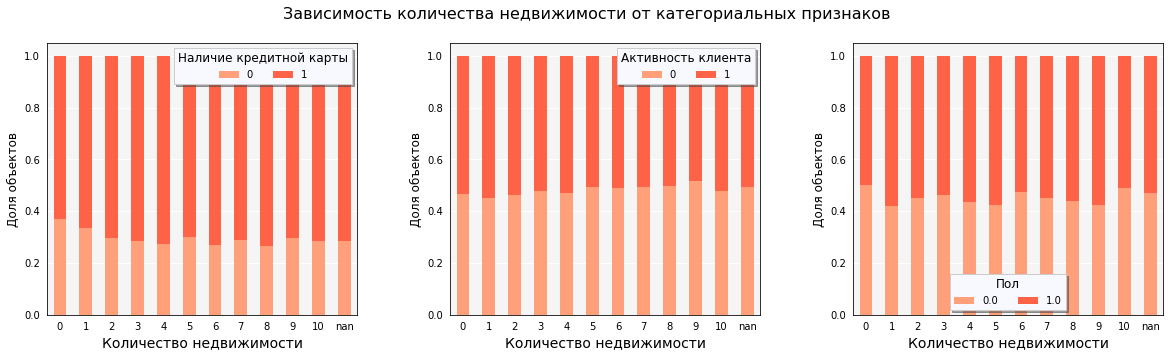

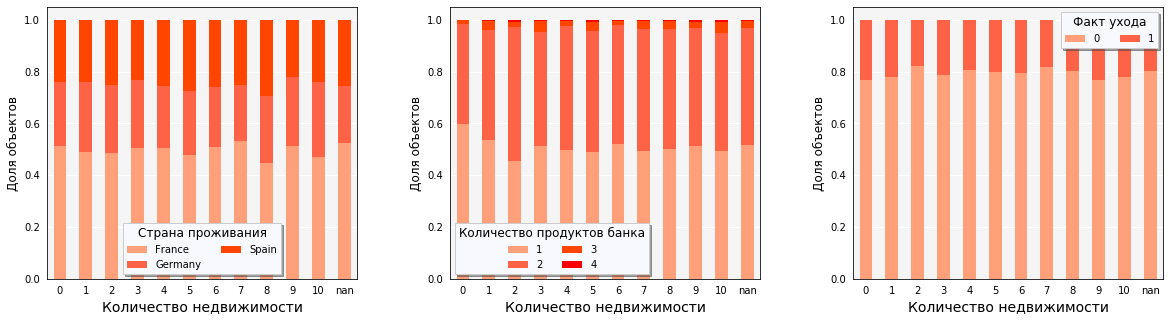

In [37]:
cols = ['has_cr_card', 'is_active_member', 'gender', 'geography', 'num_of_products', 'exited']
plot_bar(
    [data.replace(np.nan, 'nan').groupby('tenure')[col].value_counts(normalize=True).unstack() \
     for col in cols[:3]], 
    figsize=(20,5), xlabels=['Количество недвижимости']*3, legend_titles=[labels[col] for col in cols[:3]], 
    title='Зависимость количества недвижимости от категориальных признаков'
)
plot_bar(
    [data.replace(np.nan, 'nan').groupby('tenure')[col].value_counts(normalize=True).unstack() \
     for col in cols[3:]], 
    figsize=(20,5), xlabels=['Количество недвижимости']*3,  legend_titles=[labels[col] for col in cols[3:]]
)

Здесь связи тоже не видно :(

Таким образом, нельзя утверждать, что пропуск соответствуют нулевому числу недвижимости у клиента банка. Поэтому далее мы будем рассмаривать различные способы заполнения пропусков и выберем лучшую модель.

## Обработка аномалий

Аномальным кажется максимальный кредитный рейтинг 850 у большого числа клиентов банка. Изучим эти объекты детальнее.

In [38]:
data['is_max_credit_score'] = data['credit_score'].apply(lambda cr: (cr == 850) * 1)
labels['is_max_credit_score'] = 'Максимальный кредитный рейтинг'

In [39]:
data[data['is_max_credit_score'] == 1].sample(10)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,is_max_credit_score
2849,850,France,0.000,41,5,0.000,2,1,1,34827.430,0,1
3610,850,Germany,1.000,40,6,94607.080,1,1,0,36690.490,0,1
2054,850,France,1.000,63,8,169832.570,1,0,0,184107.260,1,1
6873,850,France,0.000,27,7,43658.330,2,1,1,3025.490,0,1
6028,850,Germany,1.000,44,3,140393.650,2,0,1,186285.520,0,1
9582,850,France,0.000,28,9,0.000,2,1,1,164864.670,0,1
2147,850,France,1.000,49,5,122486.470,1,0,1,59748.190,0,1
2981,850,Spain,0.000,41,3,99945.930,2,1,0,71179.310,0,1
4142,850,Spain,1.000,39,NaN,141829.670,1,1,1,92748.160,0,1
2203,850,Spain,1.000,28,9,97408.030,1,1,1,175853.640,0,1


Кажется, что клиенты с максимальным кредитным рейтингом — обычные пользователи, остальные признаки принимают адекватные значения. Сравним подвыборки клиентов с максимальным и другим кредитным рейтингом. Повторим анализ, как на предыдущем шаге.

$H_0(f):$ Распределения клиентов с `credit_score = 850` и `credit_score < 850` по признаку $f$ совпадают. 

$H_1(f):$ $H_0(f)$ неверна.

In [40]:
pvalues = pd.DataFrame({
    col: test_hypothesis(
        x=data[data['is_max_credit_score'] == 1][col], y=data[data['is_max_credit_score'] == 0][col], 
        stat='mannwhitneyu'
    ) for col in num_columns[1:4]
}, index=['p-value'])
pvalues.T.index.names = ['Признак']

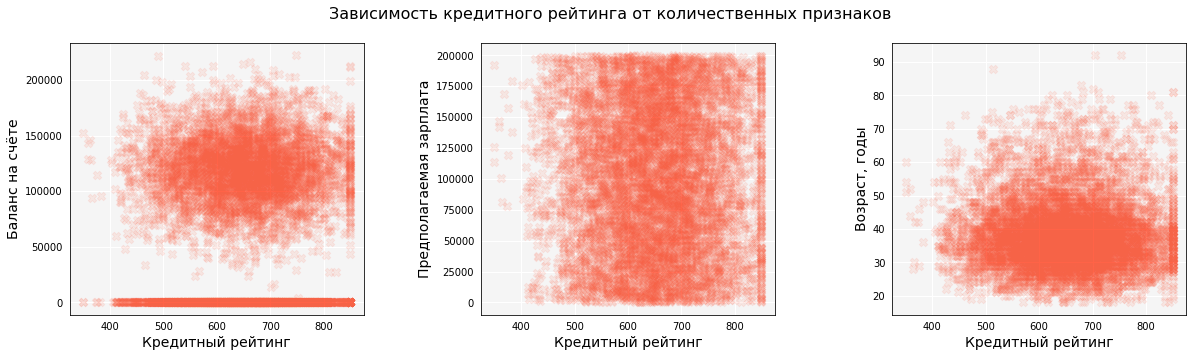

Признак,balance,estimated_salary,age
p-value,0.653,0.215,0.920


In [41]:
plot_scatter(
    [data[['credit_score', col]] for col in num_columns[1:4]], figsize=(20,5),
    alphas=[0.1,0.1,0.1], xlabels=[labels['credit_score']]*3, ylabels=[labels[col] for col in num_columns[1:4]],
    title='Зависимость кредитного рейтинга от количественных признаков' 
)
pvalues

Все три гипотезы подтверждаются.

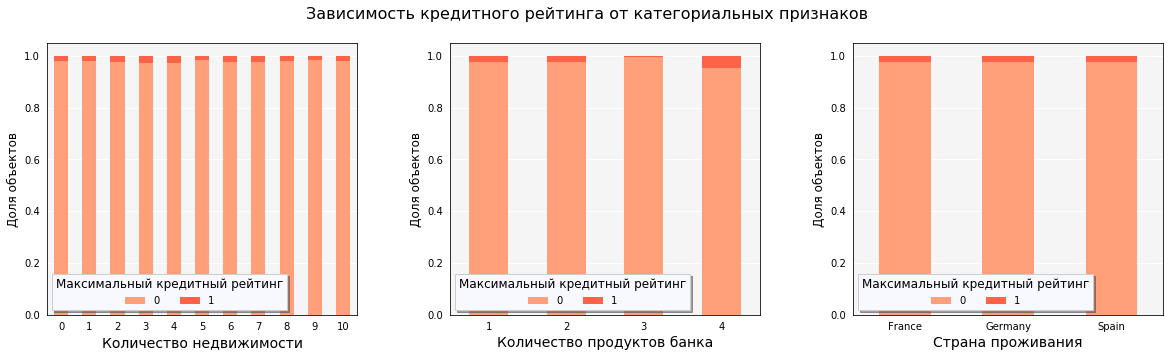

In [42]:
cols = ['tenure', 'num_of_products', 'geography']
plot_bar(
    [data.groupby(col)['is_max_credit_score'].value_counts(normalize=True).unstack() for col in cols], 
    figsize=(20,5), xlabels=[labels[col] for col in cols], legend_titles=[labels['is_max_credit_score']] * 3, 
    title='Зависимость кредитного рейтинга от категориальных признаков'
)

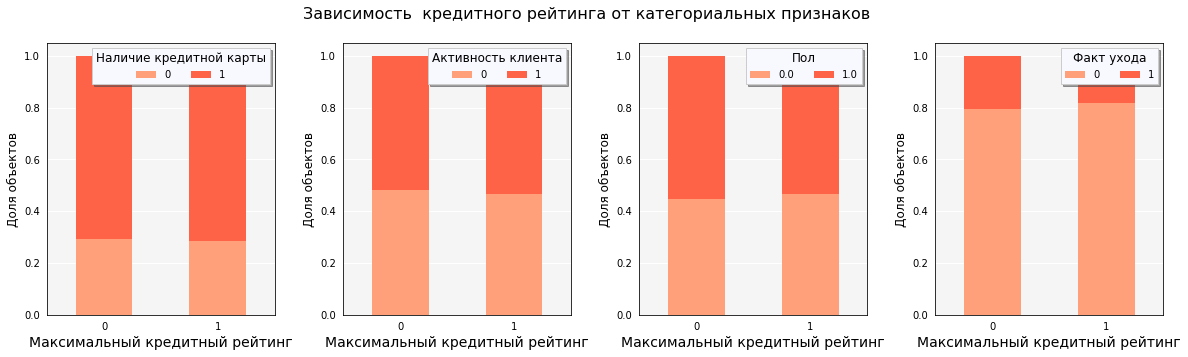

In [43]:
cols = ['has_cr_card', 'is_active_member', 'gender', 'exited']
plot_bar(
    [data.groupby('is_max_credit_score')[col].value_counts(normalize=True).unstack() for col in cols], 
    figsize=(20,5), xlabels=[labels['is_max_credit_score']] * 4, legend_titles=[labels[col] for col in cols], 
    title='Зависимость  кредитного рейтинга от категориальных признаков'
)

Таким образом, существенных отличий клиентов с максимальным кредитным рейтингом от всех остальных клиентов нет. Такие клиенты в среднем немного более активны, чаще уходят из банка. Доля женщин среди них больше, чем в среднем по выборке.  
$\to$ Будем считать допустимым такое число клиентов с `credit_score = 850`.

### Вывод<a class="tocSkip">

Предобработка завершена.
* Удалены неинформативные признаки.
* В данных отсутствуют артефакты и выбросы, число нулей допустимое. Дубликаты отсутствуют.
* Проанализированы пропуски в столбце `tenure` и способы их заполнения.
* Данные приведены к нужным типам, выбраны техники кодирования категориальных признаков.
* Выбраны способы масштабирования данных.

# Анализ данных
[к оглавлению](#start)

Прежде чем обучать модель, проанализируем данные. 

В нашем распоряжении 11 признаков. Посмотрим, есть ли связь с целевым признаком. 

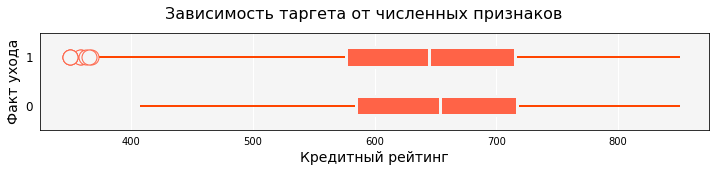

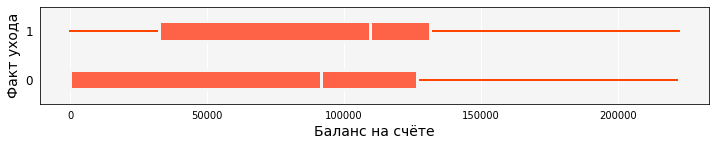

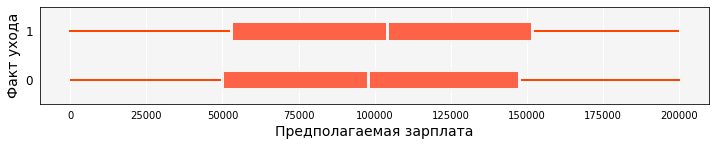

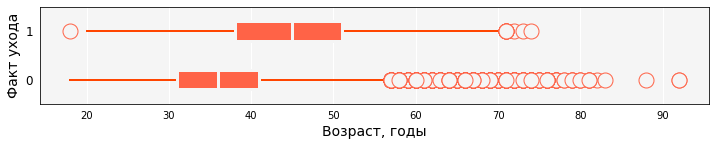

In [44]:
title = ['Зависимость таргета от численных признаков'] + [None] * 3
for i in range(4):
    plot_box(
        [data[data['exited'] == s][num_columns[i]] for s in [0,1]],
        labels=[labels[num_columns[i]], labels['exited']], ticks=[0,1], title=title[i], figsize=(12,2)
    )

Видим, что в подвыборках `exited = 0` и `exited = 1` средние значения многих признаков разные.  
Особенно сильно отличаются средний возраст, среднее количество продуктов банка и доля активных пользователей. Скорее всего, эти признаки будут полезны при построении модели :)  

На этапе предобработки было обнаружено, что среди клиентов банка у многих кредитный рейтинг максимален, баланс на счёте нулевой. Возможно, бинарные признаки `is_max_credit_score` и `is_null_balance` окажутся полезны для предсказания ухода клиента из банка.

In [45]:
data['is_null_balance'] = data['balance'].apply(lambda b: (b == 0) * 1)
labels['is_null_balance'] = 'Нулевой баланс на счёте'

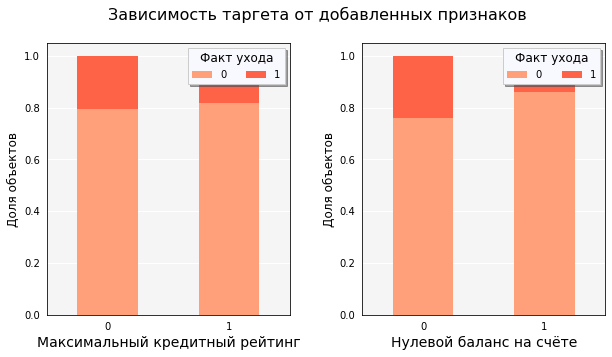

In [46]:
cols = ['is_max_credit_score', 'is_null_balance']
plot_bar(
    [data.groupby(col)['exited'].value_counts(normalize=True).unstack() for col in cols], 
    xlabels=[labels[col] for col in cols], title='Зависимость таргета от добавленных признаков', 
    legend_titles=[labels['exited']] * 2, figsize=(10,5)
)

Максимальный кредитный рейтинг, похоже, не связан с таргетом — этот признак можно удалить. А вот нулевой баланс на счёте — информативный признак :) Интересно, что среди клиентов с нулевым балансом доля ушедших значительно меньше.

In [47]:
data = data.drop(columns=['is_max_credit_score'])
test_data['is_null_balance'] = test_data['balance'].apply(lambda b: (b == 0) * 1)

Изучим взаимосвязь с оставшимися дискретными признаками. 

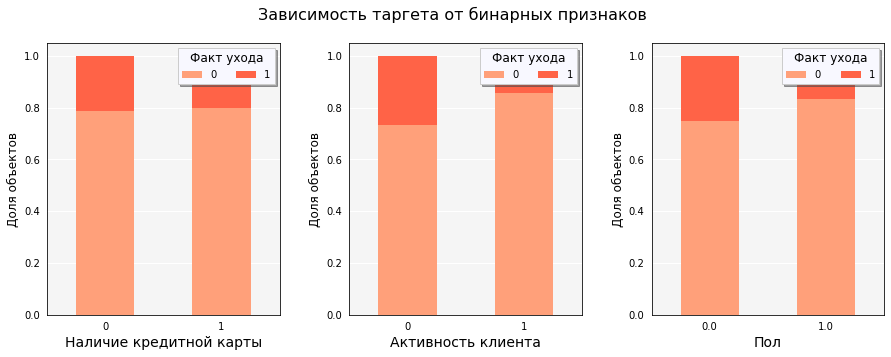

In [48]:
plot_bar(
    [data.groupby(col)['exited'].value_counts(normalize=True).unstack() for col in bool_columns], 
    xlabels=[labels[col] for col in bool_columns], title='Зависимость таргета от бинарных признаков', 
    legend_titles=[labels['exited']] * 3, figsize=(15,5)
)

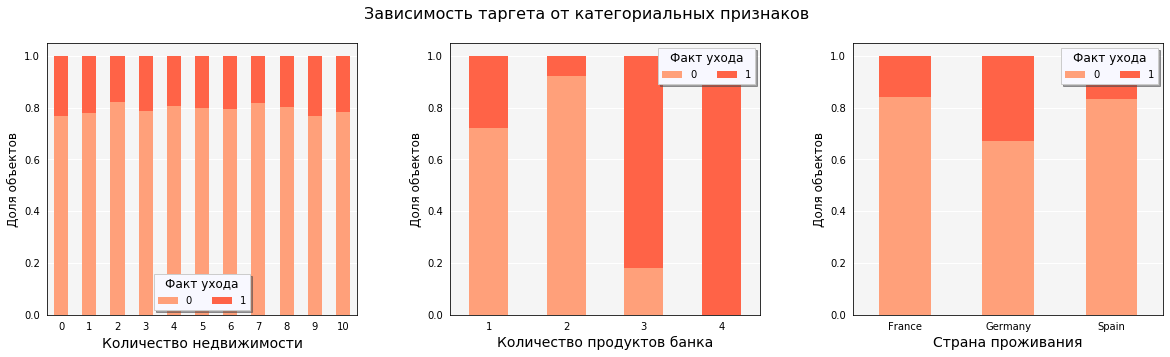

In [49]:
cols = num_columns[-2:] + ['geography']
plot_bar(
    [data.groupby(col)['exited'].value_counts(normalize=True).unstack() for col in cols], 
    xlabels=[labels[col] for col in cols], title='Зависимость таргета от категориальных признаков', 
    legend_titles=[labels['exited']] * 3, figsize=(20,5)
)

Видим, что многие категориальные признаки связаны с таргетом. В особенности, количество продуктов банка, страна проживания и активность клиента.  
Кажется странным, что все клиенты, пользовавшиеся четырьмя продуктами банка, ушли, как и большая часть клиентов, пользовавшихся тремя продуктами. Возможно, они были навязаны клиентам, из-за чего клиенты решили покинуть банк. В любом случае, банку стоит обратить внимание на эти продукты. 

### Вывод<a class="tocSkip">
Анализ данных выявил следующие особенности: <a id="res"></a>
* Выборка несбалансированная: объектов отрицательного класса в четыре раза больше, чем положительного.
* Многие из имеющихся признаков напрямую связаны с целевым. Клиенты, уходящие из банка, — это люди с зарплатой и балансом на счёте выше среднего, пользующиеся одним либо 3-4 продуктами банка. В основном это мужчины 40-50 лет, проживающие в Германии.

# Построение модели 
[к оглавлению](#start)

In [50]:
x_train = data.drop(columns=['exited'])
y_train = data['exited']
x_test = test_data.drop(columns=['exited'])
y_test = test_data['exited']

Подготовим *pipeline* построения модели. Он будет состоять из предобработки (заполнение пропусков, кодировка, масштабирование, добавление признаков второго порядка и выше) и классификации.

In [51]:
col_transformer = ColumnTransformer(remainder='passthrough', transformers=[
    ('imputer', SimpleImputer(missing_values=np.nan, fill_value=0), ['tenure']),
    ('encoder', 'passthrough', ['geography'])])

preprocessor = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', None)])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', None)])

In [52]:
imp_col = ['tenure']
cat_col = ['geography']
num_col = ['credit_score', 'gender', 'age', 'balance', 'num_of_products', 'has_cr_card', 
           'is_active_member', 'estimated_salary', 'is_null_balance']

Итак, перед нами задача бинарной классификации. Метрика качества — F1-мера.

### Проверка константной модели <a class="tocSkip">

Константная модель в нашей задаче отнесёт все объекты к классу $1$. 

In [53]:
start_predict = time.time()
prediction_const =  pd.Series([1] * len(y_test), index=y_test.index)
end_predict = time.time()
scores = pd.DataFrame({ 
    'F1': f1_score(y_test, prediction_const),
    'AUC-ROC': roc_auc_score(y_test, prediction_const),
    'accuracy': accuracy_score(y_test, prediction_const),
    'precision': precision_score(y_test, prediction_const), 
    'recall': recall_score(y_test, prediction_const),
    'learning_time': 0.,
    'prediction_time': end_predict - start_predict
}, index=['Константная модель'], dtype=float)
scores

,F1,AUC-ROC,accuracy,precision,recall,learning_time,prediction_time
Константная модель,0.338,0.500,0.204,0.204,1.000,0.000,0.000


Все метрики качества довольно низкие. Несмотря на то, что доля правильных ответов у константной модели всего 0.2, мы будем ориентироваться на значение 0.8.

## Логистическая регрессия
[к оглавлению](#start)

Начнём с обучения простой модели — логистической регрессии. Будем варьировать тип и коэффициент регуляризации, а также взвешивание классов.

Также будем сравнивать различные способы предобработки:
* заполнение пропусков — медиана/константа 0
* масштабирование — стандартизация/нормализация
* степень `PolynomialFeatures`

Кодируем категориальные признаки техникой *OHE*, т.к. использовать порядковое кодирование для линейных моделей некорректно.

In [54]:
pipeline.set_params(
    preprocessor__col_transformer__encoder = OneHotEncoder(drop='first'),
    model = LogisticRegression(random_state=42)
)

parameters_grid = {
    'preprocessor__col_transformer__imputer__strategy': ['median', 'constant'], 
    'preprocessor__col_transformer__imputer__fill_value': [0], 
    'preprocessor__poly__degree': [4], # 2 - 4
    'preprocessor__scaler': [StandardScaler(), MinMaxScaler()],
    'model__penalty': ['l1'], # ['l1', 'l2']
    'model__C': [0.1, 1.],
    'model__class_weight': [None] # 'balanced'
}

In [55]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0,1,0.05), balance=None)
gs.fit(x_train, y_train)

print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.620
Порог классификации: 0.300
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'constant',
 'preprocessor__col_transformer__imputer__fill_value': 0,
 'preprocessor__poly__degree': 4,
 'preprocessor__scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'model__penalty': 'l1',
 'model__C': 1.0,
 'model__class_weight': None}

Оптимальной оказалась лассо-регуляризация с $C=1$. Пропуски в числе недвижимости заполняются нулями, в выборку добавляются признаки 2—4 порядков, классы не взвешиваются.  
Оценим на кросс-валидации качество модели с оптимальными гиперпараметрами.

In [56]:
lr_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='constant', fill_value=1),
    'preprocessor__col_transformer__encoder': OneHotEncoder(drop='first'), 
    'preprocessor__poly': PolynomialFeatures(include_bias=False, degree=4),
    'preprocessor__scaler': MinMaxScaler(),
    'model': LogisticRegression(random_state=42, penalty='l1', C=1., class_weight=None)
}

In [57]:
cv_scores = scores.copy()
cv_scores['index_1'] = ['—']
cv_scores = cv_scores.reset_index().set_index(['index', 'index_1'])
cv_scores.index.names = ['Модель', 'Балансировка']

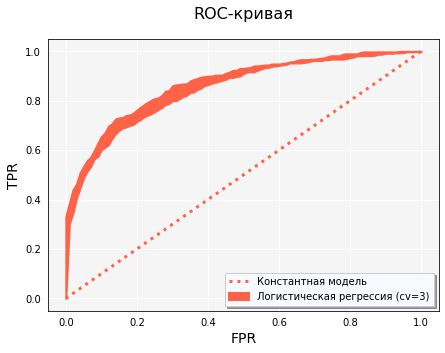

,,F1,AUC-ROC,accuracy,precision,recall,learning_time,prediction_time
Модель,Балансировка,,,,,,,
Константная модель,—,0.338,0.500,0.204,0.204,1.000,0.000,0.000
Логистическая регрессия,—,0.616,0.835,0.854,0.586,0.649,1.731,0.218


In [58]:
pipeline.set_params(**lr_params)

label = 'Логистическая регрессия'
cv_scores.loc[(label, '—'),] = \
                get_cv_scores(x_train, y_train, pipeline, threshold=0.3, roc_plot=True, label=label)
cv_scores

Качество значительно улучшилось :)  
ROC-кривая выглядит хорошо: разброс значений TPR небольшой, что говорит об устойчивости оценки.

Посмотрим на веса признаков.

In [59]:
ohe_cols = list(pipeline['preprocessor']['col_transformer'].transformers_[1][1].get_feature_names(cat_col))
poly_cols = list(pipeline['preprocessor']['poly'].get_feature_names(imp_col + ohe_cols + num_col))

In [60]:
feature_weights = pd.DataFrame(pipeline['model'].coef_, columns=poly_cols, index=['weight']).T
feature_weights.loc['intercept'] = pipeline['model'].intercept_
feature_weights.loc[feature_weights.abs().sort_values(by='weight', ascending=False).index].head(10)

,weight
num_of_products^4,26.816
age,9.647
age^3 is_active_member,-8.813
geography_Germany balance^3,-8.422
num_of_products,-5.275
intercept,-3.072
age^4,-2.759
num_of_products is_null_balance^2,-2.651
credit_score num_of_products,-2.408
geography_Germany^3 balance,2.234


Среди наиболее значимых признаков число продуктов банка, возраст, место проживания и активность клиента, а также их комбинации. Все эти признаки мы отмечали на этапе анализа данных, как информативные $\to$ модель кажется вполне адекватной :)

### Балансировка классов<a class="tocSkip">

Попробуем обучать модель на выборке, сбалансированной техниками *oversampling* / *undersampling*. Снова подберём оптимальные гиперпараметры.

In [61]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0,1,0.05), balance='over')
gs.fit(x_train, y_train)
print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.612
Порог классификации: 0.617
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'constant',
 'preprocessor__col_transformer__imputer__fill_value': 0,
 'preprocessor__poly__degree': 4,
 'preprocessor__scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'model__penalty': 'l1',
 'model__C': 0.1,
 'model__class_weight': None}

In [62]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0,1,0.05), balance='under')
gs.fit(x_train, y_train)
print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.600
Порог классификации: 0.633
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'median',
 'preprocessor__col_transformer__imputer__fill_value': 0,
 'preprocessor__poly__degree': 4,
 'preprocessor__scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'model__penalty': 'l1',
 'model__C': 1.0,
 'model__class_weight': None}

In [63]:
lr_over_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='constant', fill_value=0),
    'preprocessor__col_transformer__encoder': OneHotEncoder(drop='first'), 
    'preprocessor__poly': PolynomialFeatures(include_bias=False, degree=4),
    'preprocessor__scaler': StandardScaler(),
    'model': LogisticRegression(random_state=42, penalty='l1', C=0.1, class_weight=None)
}
lr_under_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='median'),
    'preprocessor__col_transformer__encoder': OneHotEncoder(drop='first'), 
    'preprocessor__poly': PolynomialFeatures(include_bias=False, degree=4),
    'preprocessor__scaler': MinMaxScaler(),
    'model': LogisticRegression(random_state=42, penalty='l1', C=1., class_weight=None)
}

Наборы гиперпараметров несильно изменились. Посмотрим на качество.

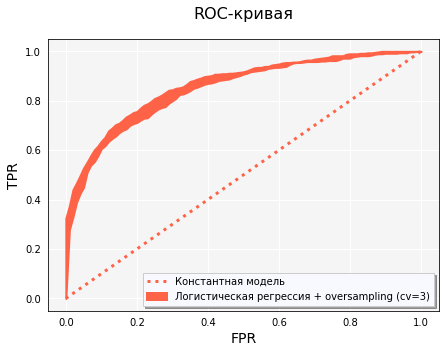

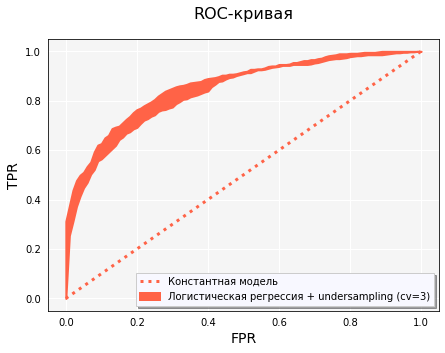

F1  AUC-ROC  accuracy  precision  \
Модель                  Балансировка                                        
Константная модель      —             0.338    0.500     0.204      0.204   
Логистическая регрессия —             0.616    0.835     0.854      0.586   
                        oversampling  0.610    0.834     0.851      0.585   
                        undersampling 0.598    0.830     0.845      0.576   

                                       recall  learning_time  prediction_time  
Модель                  Балансировка                                           
Константная модель      —               1.000          0.000            0.000  
Логистическая регрессия —               0.649          1.731            0.218  
                        oversampling    0.638          5.975            0.239  
                        undersampling   0.622          0.486            0.189

In [64]:
pipeline.set_params(**lr_over_params)
cv_scores.loc[(label,'oversampling'),] = get_cv_scores(x_train,y_train,pipeline,threshold=0.617, balance='over',
                                                       roc_plot=True, label=label + ' + oversampling')
pipeline.set_params(**lr_under_params)
cv_scores.loc[(label,'undersampling'),] = get_cv_scores(x_train,y_train,pipeline,threshold=0.633,balance='under',
                                                        roc_plot=True, label=label + ' + undersampling')
cv_scores

Все метрики качества ухудшились :( 

Видно, что на ROC-кривой для андерсэмплированной выборки разброс значений больше, что объясняется меньшим размером обучающей выборки.

## Случайный лес
[к оглавлению](#start)

Попробуем обучить более сложную модель — случайный лес.  
Будем варьировать число деревьев, их максимальную глубину, минимальное число листьев в вершине и максимальное число признаков, учитывающихся при поиске лучшего разбиения. Масштабирование и добавление признаков более высоких порядков для деревянных алгоритмов не требуется. Пропуски будем пробовать заполнять не только медианой и нулями, но и $-1$ (т.е. будем выделять отдельную категорию), также сравним *OHE* и *OE*.

In [65]:
pipeline.set_params(
    preprocessor__poly = None,
    preprocessor__scaler = None,
    model = RandomForestClassifier(random_state=42)
)

parameters_grid = {
    'preprocessor__col_transformer__imputer__strategy': ['constant'], # 'median'
    'preprocessor__col_transformer__imputer__fill_value': [-1, 0],
    'preprocessor__col_transformer__encoder': [OneHotEncoder(drop='first')], # OrdinalEncoder() 
    'model__max_depth' : [10, 15], # 5 - 25
    'model__min_samples_leaf': [5, 10], # 1 - 50
    'model__max_features' : [0.3, 0.4, 0.5], # 0.1 - 1.
    'model__class_weight': [None], # 'balanced'
    'model__n_estimators': [100, 130] # 50 - 200
}

In [66]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0, 1, 0.05), balance=None)
gs.fit(x_train, y_train)

print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.621
Порог классификации: 0.333
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'constant',
 'preprocessor__col_transformer__imputer__fill_value': -1,
 'preprocessor__col_transformer__encoder': OneHotEncoder(categorical_features=None, categories=None, drop='first',
               dtype=<class 'numpy.float64'>, handle_unknown='error',
               n_values=None, sparse=True),
 'model__max_depth': 10,
 'model__min_samples_leaf': 5,
 'model__max_features': 0.3,
 'model__class_weight': None,
 'model__n_estimators': 130}

In [67]:
rf_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='constant', fill_value=-1),
    'preprocessor__col_transformer__encoder': OneHotEncoder(drop='first'), 
    'preprocessor__poly': None,
    'preprocessor__scaler': None,
    'model': RandomForestClassifier(random_state=42, n_estimators=130, max_depth=10, 
                                    min_samples_leaf=5, max_features=0.3, class_weight=None)
}

Оптимальным оказался лес из 130 неглубоких деревьев. Пропуски запоняются $-1$, что вполне ожидаемо :)

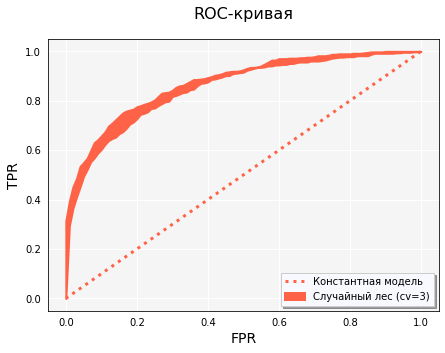

F1  AUC-ROC  accuracy  precision  \
Модель                  Балансировка                                        
Константная модель      —             0.338    0.500     0.204      0.204   
Логистическая регрессия —             0.616    0.835     0.854      0.586   
                        oversampling  0.610    0.834     0.851      0.585   
                        undersampling 0.598    0.830     0.845      0.576   
Случайный лес           —             0.616    0.849     0.858      0.641   

                                       recall  learning_time  prediction_time  
Модель                  Балансировка                                           
Константная модель      —               1.000          0.000            0.000  
Логистическая регрессия —               0.649          1.731            0.218  
                        oversampling    0.638          5.975            0.239  
                        undersampling   0.622          0.486            0.189  
Случайный лес           —               0.593          0.696            0.068

In [68]:
pipeline.set_params(**rf_params)

label = 'Случайный лес'
cv_scores.loc[(label, '—'),] = \
                get_cv_scores(x_train, y_train, pipeline, threshold=0.333, roc_plot=True, label=label)
cv_scores

Улучшилось как качество, так и скорость обучения модели :)

In [69]:
ohe_cols = list(pipeline['preprocessor']['col_transformer'].transformers_[1][1].get_feature_names(cat_col))
cols = imp_col + ohe_cols + num_col

In [70]:
feature_importances_rf = pd.DataFrame(pipeline['model'].feature_importances_, columns=['importance'], index=cols)
feature_importances_rf.sort_values(by='importance', ascending=False)

,importance
age,0.318
num_of_products,0.218
balance,0.094
estimated_salary,0.080
credit_score,0.076
is_active_member,0.067
geography_Germany,0.050
tenure,0.044
gender,0.018
is_null_balance,0.015


Список наиболее значимых признаков тоже кажется адекватным.

### Балансировка классов<a class="tocSkip">

In [71]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0, 1, 0.05), balance='over')
gs.fit(x_train, y_train)
print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.618
Порог классификации: 0.567
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'constant',
 'preprocessor__col_transformer__imputer__fill_value': 0,
 'preprocessor__col_transformer__encoder': OneHotEncoder(categorical_features=None, categories=None, drop='first',
               dtype=<class 'numpy.float64'>, handle_unknown='error',
               n_values=None, sparse=True),
 'model__max_depth': 15,
 'model__min_samples_leaf': 10,
 'model__max_features': 0.4,
 'model__class_weight': None,
 'model__n_estimators': 100}

In [72]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0, 1, 0.05), balance='under')
gs.fit(x_train, y_train)
print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.616
Порог классификации: 0.650
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'constant',
 'preprocessor__col_transformer__imputer__fill_value': 0,
 'preprocessor__col_transformer__encoder': OneHotEncoder(categorical_features=None, categories=None, drop='first',
               dtype=<class 'numpy.float64'>, handle_unknown='error',
               n_values=None, sparse=True),
 'model__max_depth': 10,
 'model__min_samples_leaf': 5,
 'model__max_features': 0.5,
 'model__class_weight': None,
 'model__n_estimators': 100}

In [73]:
rf_over_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='constant', fill_value=0),
    'preprocessor__col_transformer__encoder': OneHotEncoder(drop='first'), 
    'preprocessor__poly': None,
    'preprocessor__scaler': None,
    'model': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=15, 
                                    min_samples_leaf=10, max_features=0.4, class_weight=None)
}
rf_under_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='constant', fill_value=0),
    'preprocessor__col_transformer__encoder': OneHotEncoder(drop='first'),
    'preprocessor__poly': None,
    'preprocessor__scaler': None,
    'model': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, 
                                    min_samples_leaf=5, max_features=0.5, class_weight=None)
}

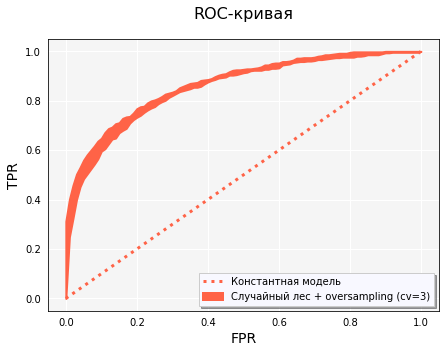

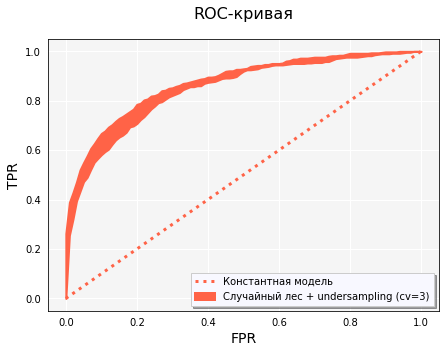

F1  AUC-ROC  accuracy  precision  \
Модель                  Балансировка                                        
Константная модель      —             0.338    0.500     0.204      0.204   
Логистическая регрессия —             0.616    0.835     0.854      0.586   
                        oversampling  0.610    0.834     0.851      0.585   
                        undersampling 0.598    0.830     0.845      0.576   
Случайный лес           —             0.616    0.849     0.858      0.641   
                        oversampling  0.614    0.843     0.856      0.616   
                        undersampling 0.608    0.835     0.856      0.590   

                                       recall  learning_time  prediction_time  
Модель                  Балансировка                                           
Константная модель      —               1.000          0.000            0.000  
Логистическая регрессия —               0.649          1.731            0.218  
                        oversampling    0.638          5.975            0.239  
                        undersampling   0.622          0.486            0.189  
Случайный лес           —               0.593          0.696            0.068  
                        oversampling    0.615          0.906            0.054  
                        undersampling   0.628          0.393            0.048

In [74]:
pipeline.set_params(**rf_over_params)
cv_scores.loc[(label,'oversampling'),] = get_cv_scores(x_train,y_train,pipeline,threshold=0.567, balance='over',
                                                       roc_plot=True, label=label + ' + oversampling')
pipeline.set_params(**rf_under_params)
cv_scores.loc[(label,'undersampling'),] = get_cv_scores(x_train,y_train,pipeline,threshold=0.650,balance='under',
                                                        roc_plot=True, label=label + ' + undersampling')
cv_scores

Как и в случае линейной модели, обучение на сбалансированной выборке ухудшает качество модели.

## Градиентный бустинг

Последняя модель, которую мы рассмотрим,  — это градиентный бустинг над решающими деревьями. Будем варьировать число деревьев, их глубину и число листьев, а также шаг градиентного спуска. Рассматриваемые параметры предобработки будут такими же, как и для случайного леса.

Поскольку `LGBMClassifier` умеет работать с категориальными признаками, сравним также автоматическую кодировку с ручной *OHE* / *OE*.

In [75]:
pipeline.set_params(
    preprocessor__poly = None,
    preprocessor__scaler = None,
    model = LGBMClassifier(random_state=42)
)

parameters_grid = {
    'preprocessor__col_transformer__imputer__strategy': ['median', 'constant'],
    'preprocessor__col_transformer__imputer__fill_value': [-1],
    'preprocessor__col_transformer__encoder': [OrdinalEncoder()], 
    'model__categorical_feature': [1], # None
    'model__max_depth': [5,9,20],
    'model__learning_rate': [0.03,0.04,0.05],
    'model__n_estimators': [120,150],
    'model__num_leaves': [20,25],
    'model__class_weight': [None] # 'balanced'
}

In [76]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0, 1, 0.05), balance=None)
gs.fit(x_train, y_train)

print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.628
Порог классификации: 0.350
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'median',
 'preprocessor__col_transformer__imputer__fill_value': -1,
 'preprocessor__col_transformer__encoder': OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>),
 'model__categorical_feature': 1,
 'model__max_depth': 5,
 'model__learning_rate': 0.04,
 'model__n_estimators': 120,
 'model__num_leaves': 20,
 'model__class_weight': None}

In [77]:
gb_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='median'),
    'preprocessor__col_transformer__encoder': OrdinalEncoder(), 
    'preprocessor__poly': None,
    'preprocessor__scaler': None,
    'model': LGBMClassifier(random_state=42, n_estimators=120, max_depth=5, categorical_feature=1,
                            num_leaves=20, learning_rate=0.04, class_weight=None)
}

Оптимальным оказалось передавть LightGBM список категориальных признаков, а не кодировать их самостоятельно :)

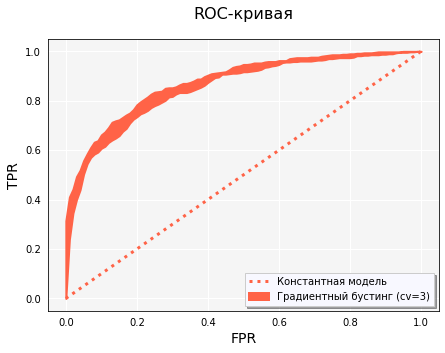

F1  AUC-ROC  accuracy  precision  \
Модель                  Балансировка                                        
Константная модель      —             0.338    0.500     0.204      0.204   
Логистическая регрессия —             0.616    0.835     0.854      0.586   
                        oversampling  0.610    0.834     0.851      0.585   
                        undersampling 0.598    0.830     0.845      0.576   
Случайный лес           —             0.616    0.849     0.858      0.641   
                        oversampling  0.614    0.843     0.856      0.616   
                        undersampling 0.608    0.835     0.856      0.590   
Градиентный бустинг     —             0.624    0.854     0.862      0.657   

                                       recall  learning_time  prediction_time  
Модель                  Балансировка                                           
Константная модель      —               1.000          0.000            0.000  
Логистическая регрессия —               0.649          1.731            0.218  
                        oversampling    0.638          5.975            0.239  
                        undersampling   0.622          0.486            0.189  
Случайный лес           —               0.593          0.696            0.068  
                        oversampling    0.615          0.906            0.054  
                        undersampling   0.628          0.393            0.048  
Градиентный бустинг     —               0.594          0.174            0.024

In [78]:
pipeline.set_params(**gb_params)

label = 'Градиентный бустинг'
cv_scores.loc[(label, '—'),] = \
            get_cv_scores(x_train, y_train, pipeline, threshold=0.35, roc_plot=True, label=label)
cv_scores

Улучшилась как точность предсказаний, так и скорость обучения.

In [79]:
cols = imp_col + cat_col + num_col

In [80]:
feature_importances_lgbm = pd.DataFrame(pipeline['model'].feature_importances_,columns=['importance'],index=cols)
feature_importances_lgbm.sort_values(by='importance', ascending=False)

,importance
balance,457
age,434
estimated_salary,322
num_of_products,288
credit_score,248
geography,150
is_active_member,110
tenure,85
gender,59
has_cr_card,14


Здесь всё тоже вполне ожидаемо.

### Балансировка классов<a class="tocSkip">

In [81]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0, 1, 0.05), balance='over')
gs.fit(x_train, y_train)
print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.630
Порог классификации: 0.633
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'constant',
 'preprocessor__col_transformer__imputer__fill_value': -1,
 'preprocessor__col_transformer__encoder': OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>),
 'model__categorical_feature': 1,
 'model__max_depth': 9,
 'model__learning_rate': 0.03,
 'model__n_estimators': 150,
 'model__num_leaves': 25,
 'model__class_weight': None}

In [82]:
gs = GridSearch(pipeline, parameters_grid, thresholds=np.arange(0, 1, 0.05), balance='under')
gs.fit(x_train, y_train)
print('F1: {:.3f}\nПорог классификации: {:.3f}\nОптимальные гиперпараметры:'.format(gs.best_score, gs.best_thr))
gs.best_params


F1: 0.629
Порог классификации: 0.667
Оптимальные гиперпараметры:


{'preprocessor__col_transformer__imputer__strategy': 'constant',
 'preprocessor__col_transformer__imputer__fill_value': -1,
 'preprocessor__col_transformer__encoder': OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>),
 'model__categorical_feature': 1,
 'model__max_depth': 20,
 'model__learning_rate': 0.05,
 'model__n_estimators': 120,
 'model__num_leaves': 20,
 'model__class_weight': None}

In [83]:
gb_over_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='constant', fill_value=-1),
    'preprocessor__col_transformer__encoder': OrdinalEncoder(), 
    'preprocessor__poly': None,
    'preprocessor__scaler': None,
    'model': LGBMClassifier(random_state=42, n_estimators=150, max_depth=9, categorical_feature=1,
                            num_leaves=25, learning_rate=0.03, class_weight=None)
}
gb_under_params = {
    'preprocessor__col_transformer__imputer': SimpleImputer(strategy='constant', fill_value=-1),
    'preprocessor__col_transformer__encoder': OrdinalEncoder(), 
    'preprocessor__poly': None,
    'preprocessor__scaler': None,
    'model': LGBMClassifier(random_state=42, n_estimators=120, max_depth=20, categorical_feature=1,
                            num_leaves=20, learning_rate=0.05, class_weight=None)
}

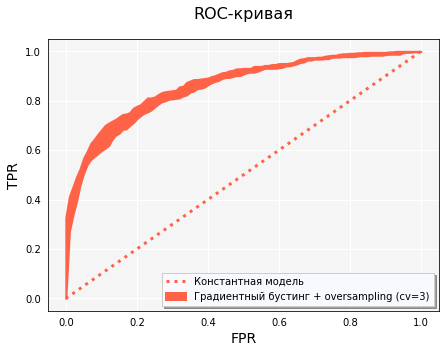

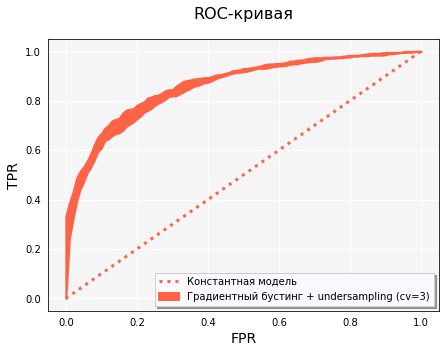

F1  AUC-ROC  accuracy  precision  \
Модель                  Балансировка                                        
Константная модель      —             0.338    0.500     0.204      0.204   
Логистическая регрессия —             0.616    0.835     0.854      0.586   
                        oversampling  0.610    0.834     0.851      0.585   
                        undersampling 0.598    0.830     0.845      0.576   
Случайный лес           —             0.616    0.849     0.858      0.641   
                        oversampling  0.614    0.843     0.856      0.616   
                        undersampling 0.608    0.835     0.856      0.590   
Градиентный бустинг     —             0.624    0.854     0.862      0.657   
                        oversampling  0.619    0.848     0.858      0.636   
                        undersampling 0.623    0.840     0.857      0.598   

                                       recall  learning_time  prediction_time  
Модель                  Балансировка                                           
Константная модель      —               1.000          0.000            0.000  
Логистическая регрессия —               0.649          1.731            0.218  
                        oversampling    0.638          5.975            0.239  
                        undersampling   0.622          0.486            0.189  
Случайный лес           —               0.593          0.696            0.068  
                        oversampling    0.615          0.906            0.054  
                        undersampling   0.628          0.393            0.048  
Градиентный бустинг     —               0.594          0.174            0.024  
                        oversampling    0.604          0.319            0.030  
                        undersampling   0.649          0.159            0.022

In [84]:
pipeline.set_params(**gb_over_params)
cv_scores.loc[(label,'oversampling'),] = get_cv_scores(x_train,y_train,pipeline,threshold=0.633, balance='over',
                                                       roc_plot=True, label=label + ' + oversampling')
pipeline.set_params(**gb_under_params)
cv_scores.loc[(label,'undersampling'),] = get_cv_scores(x_train,y_train,pipeline,threshold=0.667,balance='under',
                                                        roc_plot=True, label=label + ' + undersampling')
cv_scores

Балансировка снова ухудшает качество.

# Оценка качества
[к оглавлению](#start)

Итак, лучшее качество на кросс-валидации получилось у градиентного бустинга. Проверим теперь качество на тесте.

In [85]:
start_learn = time.time()
pipeline.set_params(**gb_params)
pipeline.fit(x_train, y_train)
end_learn = time.time()

In [86]:
start_predict = time.time()
probas = pipeline.predict_proba(x_test)[:,1]
y_pred = pd.Series(probas > 0.35, index=x_test.index)
end_predict = time.time()

In [87]:
scores.loc['Градиентный бустинг'] = [
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, probas),
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    end_learn - start_learn,
    end_predict - start_predict
]
scores

,F1,AUC-ROC,accuracy,precision,recall,learning_time,prediction_time
Константная модель,0.338,0.500,0.204,0.204,1.000,0.000,0.000
Градиентный бустинг,0.646,0.874,0.859,0.662,0.631,0.324,0.048


Качество на тесте лучше, чем на валидации. Вероятно, это связано с большим объёмом обучающей выборки.

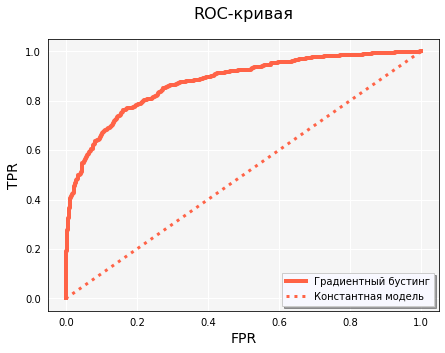

In [88]:
fpr, tpr, _ = roc_curve(y_test, probas, pos_label=1)
plot_roc(fpr, tpr, label='Градиентный бустинг')

In [89]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['y=0', 'y=1'], columns=['a(x)=0', 'a(x)=1'])

,a(x)=0,a(x)=1
y=0,1827,164
y=1,188,321


Модель совершает больше FP ошибок. Однако в целом она научилась лучше предсказывть объекты положительного класса: модель верно классифицировала 0.92 клиентов, оставшихся в банке, и всего 0.63 ушедших.

In [90]:
features = ['tenure', 'geography', 'credit_score', 'gender', 'age', 'balance',
            'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'is_null_balance']

In [91]:
feature_importances_lgbm = pd.DataFrame(pipeline['model'].feature_importances_, columns=['importance'], 
                                        index=features)
feature_importances_lgbm.sort_values(by='importance', ascending=False)

,importance
balance,717
estimated_salary,646
age,599
credit_score,592
num_of_products,335
geography,224
tenure,216
is_active_member,129
gender,97
has_cr_card,42


Наиболее значимые признаки:
* численные  — баланс а счёте, зарплата, возраст и кредитный рейтинг
* дискретные  — число продуктов банка и страна проживания

## Анализ остатков<a class="tocSkip">

In [92]:
resid = pd.DataFrame({'true': y_test, 'pred': probas})
resid['delta'] = resid['pred'] - resid['true']

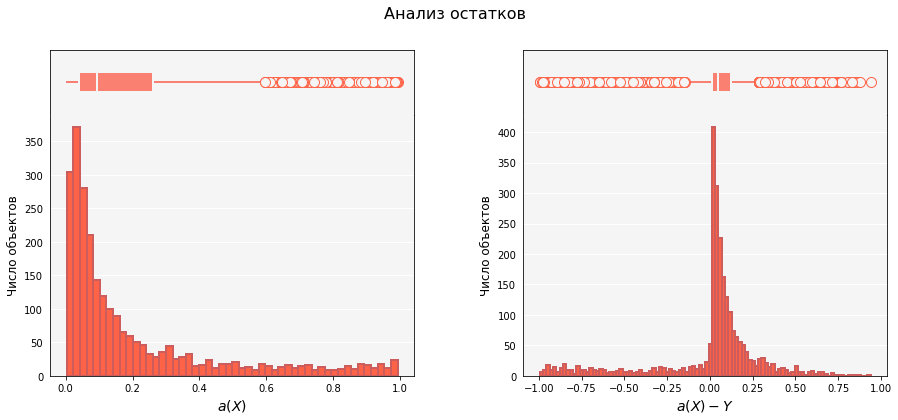

,pred,delta
min,0.003,-0.995
mean,0.204,0.000
50%,0.095,0.048
max,0.994,0.941


In [93]:
plot_distribution([resid['pred'], resid['delta']], ['$a(X)$', '$a(X) - Y$'],
                  bins=[50, 100], figsize=(15,6), title='Анализ остатков')

resid[['pred', 'delta']].describe().loc[['min', 'mean', '50%', 'max']]

На графике слева видим распределение вероятностей классов, предсказанных моделью. Все объекты с $a(x) \le 0.35$ модель отнесла к классу $0$, остальные — к классу $1$. На рисунке справа показано распределение остатков модели. В целом, можно сказать, что модель склонна сомневаться, классифицируя клиента как покинувшего банк.

Посмотрим, случайны ли ошибки модели или они зависят от значений признаков. Для этого сравним подвыборки клиентов, правильно и не правильно классифицированных моделью.

In [94]:
test_data['true_pred'] = (y_test == y_pred)
test_data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,is_null_balance,true_pred
2606,635,Spain,0.000,34,5,98683.470,2,1,0,15733.190,0,0,True
9718,757,Spain,1.000,30,3,145396.490,1,0,1,198341.150,0,0,True
69,661,Germany,0.000,35,5,150725.530,2,0,1,113656.850,0,0,True
9398,766,France,0.000,52,7,92510.900,2,0,1,66193.610,0,0,True
4005,530,Spain,0.000,41,4,0.000,2,0,1,147606.710,0,1,True


$H_0(f):$ Распределения клиентов, правильно/не правильно классифицированных моделью по признаку $f$, совпадают. 

$H_1(f):$ $H_0(f)$ неверна.

In [95]:
pvalues = pd.DataFrame({
    col: test_hypothesis(
        x=test_data[test_data['true_pred']][col], y=test_data[~test_data['true_pred']][col], stat='mannwhitneyu'
    ) for col in num_columns[:4]
}, index=['p-value'])
pvalues.columns.names = ['Признак']
pvalues

Признак,credit_score,balance,estimated_salary,age
p-value,0.438,0.000,0.664,0.000


Гипотезы для кредитного рейтинга и зарплаты подтверждаются — ошибки модели, вероятнее всего, не связаны с этими признаками. Гипотезы для возраста и баланса на счёте уверенно отвергаются.  
Сравним распределения клиентов по возрасту и балансу в подвыборках `true_pred = False` и `true_pred=True`.

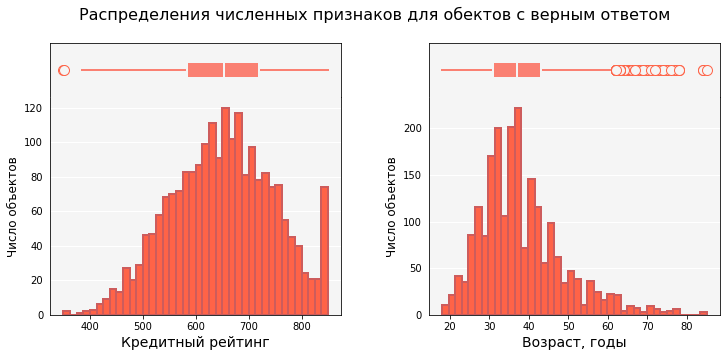

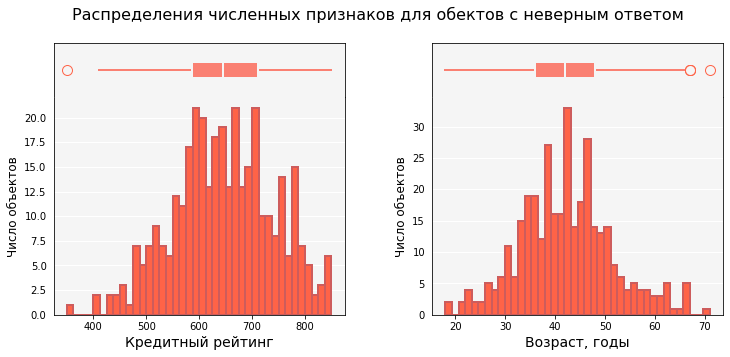

In [96]:
cols = ['credit_score', 'age']
plot_distribution(
    [test_data[test_data['true_pred']][col] for col in cols], kind='hist', bins=[40] * 2, 
    figsize=(12,5), xlabels=[labels[col] for col in cols], 
    title='Распределения численных признаков для обектов с верным ответом'
)
plot_distribution(
    [test_data[~test_data['true_pred']][col] for col in cols], kind='hist', bins=[40] * 2, 
    figsize=(12,5), xlabels=[labels[col] for col in cols], 
    title='Распределения численных признаков для обектов с неверным ответом'
)

Визуально гистограммы отличаются $\to$ ошибки модели не случайны. Видим, что модель хорошо научилась классифицировать клиентов со средним и максимальным кредитным рейтингом, а также клиентов возраста ниже среднего. На остальных клиентах она склонна чаще ошибаться.

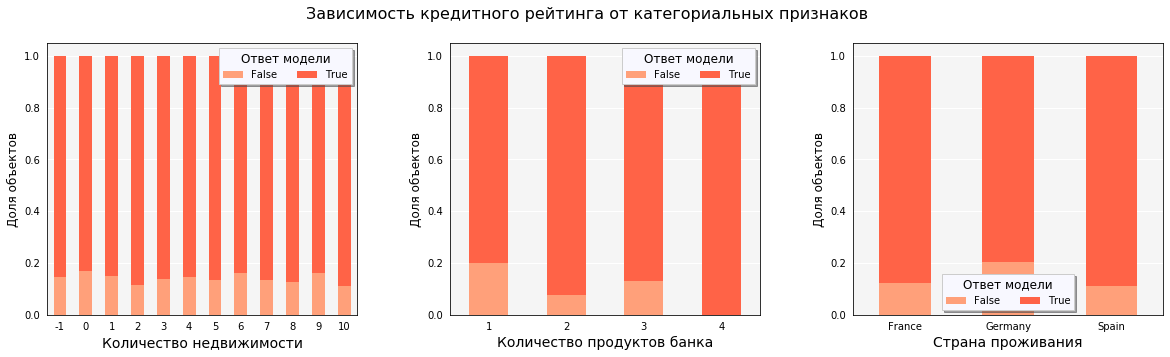

In [97]:
cols = ['tenure', 'num_of_products', 'geography']
plot_bar(
    [test_data.replace(np.nan, -1).groupby(col)['true_pred'].value_counts(normalize=True).unstack() 
             for col in cols], 
    figsize=(20,5), xlabels=[labels[col] for col in cols], legend_titles=['Ответ модели'] * 3, 
    title='Зависимость кредитного рейтинга от категориальных признаков'
)

Количество недвижимости и количество продуктов банка не влияет на долю ошибок. Клиентам из Германии модель выдаёт ошибочные предсказания. 

# Общий вывод 
[к оглавлению](#start)

Исследование оттока клиентов банка завершено.

1. Выполнена предобработка данных.
2. Проведён исследовательский анализ данных. Изучены распределения клиентов по имеющимся признакам. Проанализированы взаимосвязи между признаками и их корреляция с целевой переменной.
3. Построены несколько моделей машинного обучения на основе трёх алгоритмов, с хорошей точностью предсказывающие, уйдёт клиент из банка в ближайшее время или нет. Подобраны оптимальные гиперпараметры, проанализированы сильные и слабые стороны моделей.

## Основные результаты<a class="tocSkip">
    
1. Кросс-валидационные оценки качества моделей и время их обучения/предсказания представлены в таблице:

In [98]:
cv_scores

F1  AUC-ROC  accuracy  precision  \
Модель                  Балансировка                                        
Константная модель      —             0.338    0.500     0.204      0.204   
Логистическая регрессия —             0.616    0.835     0.854      0.586   
                        oversampling  0.610    0.834     0.851      0.585   
                        undersampling 0.598    0.830     0.845      0.576   
Случайный лес           —             0.616    0.849     0.858      0.641   
                        oversampling  0.614    0.843     0.856      0.616   
                        undersampling 0.608    0.835     0.856      0.590   
Градиентный бустинг     —             0.624    0.854     0.862      0.657   
                        oversampling  0.619    0.848     0.858      0.636   
                        undersampling 0.623    0.840     0.857      0.598   

                                       recall  learning_time  prediction_time  
Модель                  Балансировка                                           
Константная модель      —               1.000          0.000            0.000  
Логистическая регрессия —               0.649          1.731            0.218  
                        oversampling    0.638          5.975            0.239  
                        undersampling   0.622          0.486            0.189  
Случайный лес           —               0.593          0.696            0.068  
                        oversampling    0.615          0.906            0.054  
                        undersampling   0.628          0.393            0.048  
Градиентный бустинг     —               0.594          0.174            0.024  
                        oversampling    0.604          0.319            0.030  
                        undersampling   0.649          0.159            0.022

Все модели вменяемы: их качество лучше, чем у константной.

Оптимальные гиперпараметры лучших моделей для каждого из алгоритмов:

| Модель | Пропуски | Кодировка | Масштабирование | Другие признаки | Другие параметры | Балансировка классов | Порог классификации |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Линейная регрессия | 0 | OHE | нормализация | 2—4 порядка | $\ell_1$-регуляризация с $C=1$ | — | 0.33 |
| Случайный лес | -1 | OHE | — | — | 130 деревьев с max_depth=10, min_samples_leaf=5 и max_features=0.3 | — | 0.30 |
| Градиентный бустинг | -1 | auto | — | — | 150 итераций с max_depth=20, num_leaves=25 и  learning_rate=0.05| — | 0.35 |

Лучшей моделью является градиентный бустинг. Она превосходит остальные по качеству: не только F1, но и ROC-AUC и доля правильных ответов у неё самые высокие. Кроме того, она быстрее других моделей обучается и делает предсказания.

2. Оценка качества и скорости обучения/предсказания лучшей модели на тестовой выборке представлена в таблице:

In [101]:
scores.iloc[1:, ]

,F1,AUC-ROC,accuracy,precision,recall,learning_time,prediction_time
Градиентный бустинг,0.646,0.874,0.859,0.662,0.631,0.324,0.048


Анализ предсказаний модели показал, что ошибки  модели не случайны. Модель склонна чаще неверно классифицировать клиентов из Германии с низким кредитным рейтингом и возрастом выше среднего. Это означает, что потенциально качество модели можно улучшить.